# 2. Classification

In [2]:
import time 
start_time = time.time()

In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import *
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, classification_report
from sklearn.pipeline import Pipeline

#classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier 

## Preprocessing

In [3]:
training_set = pd.read_csv("training_set_complete.csv")
test_set = pd.read_csv("test_set_complete.csv")
training_set = training_set.drop(columns=['Unnamed: 0'])
test_set = test_set.drop(columns=['Unnamed: 0'])
training_set['Revenue'] = training_set['Revenue'].astype(int)
test_set['Revenue'] = test_set['Revenue'].astype(int)
training_set['Revenue'].value_counts()
test_set['Revenue'].value_counts()
categorical_features = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']
training_set[categorical_features] = training_set[categorical_features].astype('category')
test_set[categorical_features] = test_set[categorical_features].astype('category')

0    7807
1    1441
Name: Revenue, dtype: int64

0    2615
1     467
Name: Revenue, dtype: int64

In [4]:
X_train_full = training_set.drop(columns=['Revenue'])
X_test_full = test_set.drop(columns=['Revenue'])
y_train = training_set['Revenue']
y_test = test_set['Revenue']

### Variance selection
We apply variance selection to remove all the features with a very low variance.

In [5]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.001  # Soglia di varianza desiderata
variance_selector = VarianceThreshold(threshold=threshold)

# Applicazione della selezione della varianza sul dataset

X_train = X_train_full.loc[:, variance_selector.fit(X_train_full).get_support()]
columns_remaining = X_train.columns.tolist()

X_test = X_test_full[columns_remaining]
print(X_train.columns.tolist())
len(columns_remaining)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other'

65

### Functions and algorithms

#### Feature selection: Forward stepwise selection
We chose this algorithm because it's more scalable on a big dataset.

In [13]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator


possible_models = {
    "LogisticRegression":LogisticRegression(solver="newton-cg", penalty='none',max_iter=1000),
    "LDA":LDA(),
    "QDA":QDA(),
    #"KNN":KNeighborsClassifier(n_neighbors=6),
    "LinearRegression":LinearRegression(fit_intercept=True),
}

#da qui inizia il ctrl Z

def forward_selection(Xtrain_pd, ytrain, model_chosen,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    
    
    for dim in range(num_features):
        candidate_metrics = [] # metrics for all the models with dim features
        candidate_models = []  # models with dim features
        
        remaining_features = all_features.difference(selected_features)
        
        # fit all the models with k features
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = possible_models[model_chosen]
            #print(new_column)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        
        idx_best_candidate = candidates_argbest(candidate_metrics) # select the best Mk model
        selected_features.append(remaining_features[idx_best_candidate]) # Update selected feature
        best_candidate_metric.append(candidate_metrics[idx_best_candidate]) # Save best candidate features
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for the final step -> comparison of all the best models
        best_subset_model = candidate_models[idx_best_candidate] # save the best model
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score) #computing the metrics for the training set
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # choose the best candidates
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n Best configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    return best_features
    

#### Accuracy

In [14]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

def calculate_sensitivity_specificity(confusion_matrix):
    # Extract values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix.ravel()

    # Calculate Sensitivity (Recall)
    sensitivity = TP / (TP + FN)

    # Calculate Specificity
    specificity = TN / (TN + FP)

    return sensitivity, specificity

#### Evaluation metrics

In [15]:
from sklearn.metrics import confusion_matrix

def classification_metrics_training(model, model_name, X_train, y_train, cv):
    #sensitivity
    sensitivity_train = np.mean(np.absolute(cross_val_score(model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)))
    
    #specificity
    specificity_train = np.mean(np.absolute(cross_val_score(model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)))
    
    #accuracy
    accuracy_train = np.mean(np.absolute(cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)))
                         
    # building a dataframe
    data = {
        'Model': [model_name],
        'Accuracy': [accuracy_train],
        'Sensitivity': [sensitivity_train],
        'Specificity': [specificity_train],
    }
    return pd.DataFrame(data)                    

In [16]:
def classification_metrics_test(model, model_name,X_train,y_train,X_test,y_test,threshold):
    # building the confusion matrix for test performances
    model = model.fit(X_train,y_train)
    #ypred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class (class 1)

    # Convert probabilities to binary predictions
    ypred = (y_pred_proba > threshold).astype(int)
    
    cm = confusion_matrix(y_test.to_numpy(), np.array(ypred))
    sensitivity_test, specificity_test = calculate_sensitivity_specificity(cm)
    
    accuracy_test = accuracy(ypred, y_test)
    
    # building a dataframe
    data = {
        'Model': [model_name],
        'Accuracy': [accuracy_test],
        'Sensitivity': [sensitivity_test],
        'Specificity': [specificity_test],
    }
    return pd.DataFrame(data), cm

In [17]:
# We compute the empirical threshold
empirical_threshold = y_train.mean()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def classification_metrics_empirical_threshold(model, model_name, X_train, y_train,threshold=0.5):
    
    model = model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probability of positive class (class 1)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba > threshold).astype(int)

    # Evaluate the performance using various metrics
    accuracy = accuracy_score(y_train, y_pred)
    specificity = precision_score(y_train, y_pred)
    sensitivity = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    data = {
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
    }
    return pd.DataFrame(data) 


## Logistic regression

### Scaling data
We scale the numerical features to avoid convergence problem with logistic regression.

In [18]:
# FACCIAMO QUESTO STEP PER EVITARE PROBLEMI DI CONVERGENZA NEL MODELLO
from sklearn.preprocessing import StandardScaler

# Assuming you have your feature data X
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 
                        'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5',
                        'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 
                        'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 
                        'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 
                        'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]))
test_scaled = pd.DataFrame(scaler.fit_transform(X_test[numeric_features]))
train_scaled.columns = X_train[numeric_features].columns
test_scaled.columns = X_test[numeric_features].columns
X_train_scaled = pd.concat([train_scaled,X_train[categorical_features]],axis=1)
X_test_scaled = pd.concat([test_scaled,X_test[categorical_features]],axis=1)

### Feature selection

In [20]:
cv = 5
features_logistic = forward_selection(X_train_scaled, y_train, "LogisticRegression",
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=False, weight_step3=cv)
features_logistic

['PageValues',
 'VisitorType_New_Visitor',
 'TrafficType_3',
 'TrafficType_10',
 'Browser_7',
 'Region_8',
 'TrafficType_11',
 'Browser_3',
 'Browser_8',
 'Month_Feb',
 'Browser_1',
 'OperatingSystems_8',
 'Region_5',
 'Month_Aug',
 'TrafficType_7',
 'TrafficType_9',
 'Region_2',
 'Browser_13',
 'OperatingSystems_6',
 'Browser_4',
 'VisitorType_Other',
 'Browser_5',
 'Region_6']

### Evaluation Metrics

In [21]:
model_logistic = LogisticRegression(solver="newton-cg",penalty="none",max_iter=1000)
train_scores_logistic = classification_metrics_training(model_logistic, "LogisticRegression", X_train_scaled[features_logistic], y_train,5)
train_scores_logistic

,Model,Accuracy,Sensitivity,Specificity
0,LogisticRegression,0.884515,0.365686,0.773116


The sensitivity is very low, we try to improve it using the empirical threshold

In [14]:
train_scores_logistic_empirical = classification_metrics_empirical_threshold(model_logistic, 'LogisticRegression', X_train_scaled[features_logistic], y_train,empirical_threshold)
train_scores_logistic_empirical

,Model,Accuracy,Sensitivity,Specificity
0,LogisticRegression,0.88138,0.646079,0.613307


In [15]:
test_scores_logistic, cm_logistic = classification_metrics_test(model_logistic,"LogisticRegression", X_train_scaled[features_logistic], y_train,X_test_scaled[features_logistic], y_test,empirical_threshold)
test_scores_logistic

,Model,Accuracy,Sensitivity,Specificity
0,LogisticRegression,0.893251,0.67666,0.931931


# LDA

### Feature selection

In [23]:
cv = 5
features_LDA = forward_selection(X_train_scaled, y_train, "LDA",
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=False, weight_step3=cv)
features_LDA

['PageValues',
 'ExitRates',
 'BounceRates',
 'Month_Oct',
 'VisitorType_Other',
 'TrafficType_5',
 'OperatingSystems_1',
 'Browser_3',
 'Browser_7',
 'Browser_8',
 'Month_Aug',
 'Month_Sep',
 'OperatingSystems_4',
 'Month_Feb',
 'Region_3',
 'Browser_4',
 'Region_7',
 'TrafficType_11',
 'TrafficType_10',
 'OperatingSystems_6',
 'OperatingSystems_8',
 'Region_5',
 'Region_6',
 'TrafficType_15',
 'TrafficType_19',
 'TrafficType_4']

### Evaluation metrics

In [24]:
model_LDA =LDA(store_covariance=True)
train_scores_LDA = classification_metrics_training(model_LDA, "LDA", X_train[features_LDA], y_train, 5)
train_scores_LDA

,Model,Accuracy,Sensitivity,Specificity
0,LDA,0.880839,0.325442,0.782345


We try to improve the sensitivity by setting the empirical threshold

In [25]:
train_scores_LDA_empirical = classification_metrics_empirical_threshold(model_LDA, 'LDA', X_train_scaled[features_LDA], y_train,empirical_threshold)
train_scores_LDA_empirical

,Model,Accuracy,Sensitivity,Specificity
0,LDA,0.889273,0.56211,0.673317


In [26]:
test_scores_LDA, cm_LDA = classification_metrics_test(model_LDA, "LDA",X_train[features_LDA], y_train,X_test[features_LDA], y_test,empirical_threshold)
test_scores_LDA

,Model,Accuracy,Sensitivity,Specificity
0,LDA,0.899416,0.61242,0.950669


## QDA

### Feature selection

In [28]:
import warnings
warnings.filterwarnings("ignore")
cv = 5
features_QDA = forward_selection(X_train_scaled, y_train, "QDA",
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=False, weight_step3=cv)
features_QDA

['PageValues', 'BounceRates', 'VisitorType_New_Visitor', 'Browser_7']

### Evaluation

In [29]:
model_QDA = QDA(store_covariance=True)
train_scores_QDA = classification_metrics_training(model_QDA, "QDA", X_train[features_QDA], y_train, 5)
train_scores_QDA

,Model,Accuracy,Sensitivity,Specificity
0,QDA,0.889706,0.46423,0.729627


The sensitivity is very high with respect to the specificity, so we try to set the empirical threshold

In [30]:
train_scores_QDA_empirical = classification_metrics_empirical_threshold(model_QDA, 'QDA', X_train_scaled[features_QDA], y_train, empirical_threshold)
train_scores_QDA_empirical

,Model,Accuracy,Sensitivity,Specificity
0,QDA,0.800822,0.686329,0.415721


In [31]:
test_scores_QDA, cm_QDA = classification_metrics_test(model_QDA,"QDA",X_train[features_QDA], y_train,X_test[features_QDA], y_test,empirical_threshold)
test_scores_QDA

,Model,Accuracy,Sensitivity,Specificity
0,QDA,0.815704,0.728051,0.831358


## KNN

### With all features

In [32]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [33]:
model_KNN_all = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}
cv = GridSearchCV(model_KNN_all, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 15)},
             scoring=make_scorer(accuracy))

In [34]:
from sklearn.neighbors import KNeighborsClassifier
model_KNN_all = KNeighborsClassifier(n_neighbors=cv.best_params_['n_neighbors'])
train_scores_KNN_all = classification_metrics_training(model_KNN_all, "KNN", X_train, y_train, 5)
train_scores_KNN_all

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.862673,0.211649,0.694549


In [35]:
train_scores_KNN_all_empirical = classification_metrics_empirical_threshold(model_KNN_all, 'KNN', X_train, y_train,empirical_threshold)
train_scores_KNN_all_empirical

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.728482,1.0,0.364626


In [36]:
test_scores_KNN_all, cm_KNN_all = classification_metrics_test(model_KNN_all, "KNN", X_train, y_train, X_test, y_test,empirical_threshold)
test_scores_KNN_all

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.665152,0.815846,0.638241


### With only numeric features
KNN has two main issues: 
1. It is not scalable with a large amount of features
2. It relies on a distance metric to compute the distance between points. This distance may not be significant in case of categorical variables (even if we use one-hot encoding)
3. From the previous analysis we can also notice that even with the empirical threshold the performances don't improve significantly

So for these reasons we also fit a model with just the numeric features.

In [37]:
model_KNN_numeric = KNeighborsClassifier()
params = {'n_neighbors': range(1, 50)}
cv = GridSearchCV(model_KNN_numeric, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_train[numeric_features], y_train)
model_KNN_numeric = KNeighborsClassifier(n_neighbors=cv.best_params_['n_neighbors'])


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50)},
             scoring=make_scorer(accuracy))

In [38]:
train_scores_KNN_numeric = classification_metrics_training(model_KNN_numeric, "KNN", X_train[numeric_features], y_train, 5)
train_scores_KNN_numeric

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.862565,0.210955,0.693827


In [39]:
train_scores_KNN_numeric_empirical = classification_metrics_empirical_threshold(model_KNN_numeric, 'KNN', X_train[numeric_features], y_train, empirical_threshold)
train_scores_KNN_numeric_empirical

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.727941,0.998612,0.364027


In [40]:
test_score_KNN_numeric, cm_KNN_numeric = classification_metrics_test(model_KNN_numeric, "KNN",X_train[numeric_features], y_train, X_test[numeric_features], y_test,empirical_threshold)
test_score_KNN_numeric

,Model,Accuracy,Sensitivity,Specificity
0,KNN,0.664828,0.815846,0.637859


## SVM

In [35]:
end_time = time.time()
total_time = (end_time - start_time)

print(f"Tempo totale di esecuzione: {total_time:.2f} sec")

Tempo totale di esecuzione: 8.67 minuti


In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


start_time=time.time()

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
score = []
for kern in kernels:
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    print(kern)
    start_time2=time.time()
    if kern == 'linear':
        print('sono linear...')
        model_SVM = LinearSVC()
    else:
        print('nonlinear')
        model_SVM = SVC(kernel=kern)
    scores = cross_val_score(model_SVM, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    end_time2 = time.time()
    total_time2 = (end_time2 - start_time2)

    print(f"Tempo totale di esecuzione: {total_time2:.2f} sec")
    score.append(np.mean(scores))


max_index = score.index(max(score))
best_kernel = kernels[max_index]
acc_best_model = max(score)
end_time = time.time()
total_time = (end_time - start_time)

print(f"Tempo totale di esecuzione: {total_time:.2f} sec")

linear
sono linear...
Tempo totale di esecuzione: 3.71 sec
rbf
nonlinear
Tempo totale di esecuzione: 6.89 sec
poly
nonlinear


## Algorithm comparison

LogisticRegression(max_iter=1000, penalty='none', solver='newton-cg')

LinearDiscriminantAnalysis(store_covariance=True)

QuadraticDiscriminantAnalysis(store_covariance=True)

KNeighborsClassifier(n_neighbors=6)

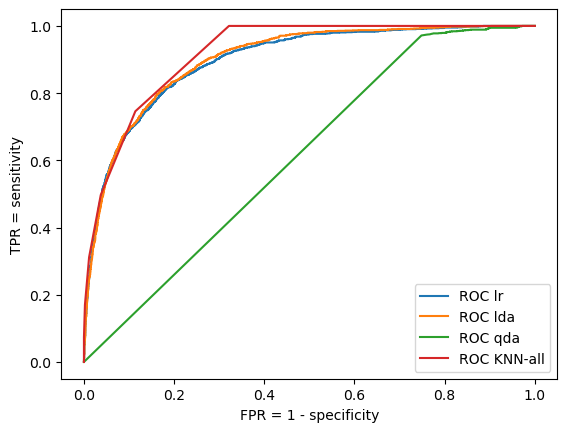

In [56]:
from sklearn.metrics import roc_curve

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

lr = LogisticRegression()
lr_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('lda', LogisticRegression())])

lda = LDA()
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA())])
qda = QDA()

svc = SVC(C=75, degree=2, kernel='poly',  probability=True)

knn = KNeighborsClassifier(n_neighbors=3)

for name, model in [('lr', model_logistic), 
                    ('lda', model_LDA), 
                    ('qda', model_QDA),
                    #('SVC', model_SVM),
                    ('KNN-all', model_KNN_all),
                    ('KNN-numeric', model_KNN_numeric)
                   ]:
    model.fit(X_train, y_train) # sistemare questa parte, fitta i modelli prima in modo che sia tutto ok
    plot_roc(model.predict_proba, X_train, y_train, name)